# Urdu Caption Generation

# **Importing Libraries**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from nltk.translate.bleu_score import sentence_bleu
import cv2
from google.colab.patches import cv2_imshow

# **Mounting Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Downloading Dataset from Kaggle**

In [ ]:
# Install Kaggle API
!pip install kaggle
import os
from google.colab import drive, files

# Upload kaggle.json file for Kaggle API authentication
uploaded = files.upload()

# Ensure .kaggle directory exists and move kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#kaggle_dataset_url = 'adityajn105/flickr8k'
kaggle_dataset_url = 'hsankesara/flickr-image-dataset'


# Download the Kaggle dataset (but do not unzip)
!kaggle datasets download -d {kaggle_dataset_url}

"""
# Path to the folder where you want to save the zipped dataset in your Google Drive
save_dir = '/content/drive/MyDrive/DL-Project'

# Move the zipped file to the "DL Project" folder in Google Drive
!mv flickr-image-dataset.zip {save_dir}
"""

Saving kaggle.json to kaggle.json
100% 8.16G/8.16G [06:23<00:00, 22.4MB/s]
100% 8.16G/8.16G [06:23<00:00, 22.9MB/s]


'\n# Path to the folder where you want to save the zipped dataset in your Google Drive\nsave_dir = \'/content/drive/MyDrive/DL-Project\'\n\n# Move the zipped file to the "DL Project" folder in Google Drive\n!mv flickr-image-dataset.zip {save_dir}\n'

# **Unzipping Dataset (From Google Drive)**

In [ ]:
%%capture
# unzipping Images
#!unzip "./gdrive/MyDrive/DL-Project/flickr8k.zip"
#!unzip "/content/drive/MyDrive/DL-Project/flickr-image-dataset.zip"
!unzip "/content/flickr-image-dataset.zip"


## **Loading Captions**

In [2]:
# Loading Captions
caption_file_path='/content/drive/MyDrive/DL-Project/captions_30k.json'

with open(caption_file_path, 'r') as j:
    data = json.load(j)

In [3]:
# Captions and image names are gotten from JSON file and stored in their respective arrays.
train_captions = []
image_filenames = []

for i in range(0,1000):
    for j in range(5):
        image_filenames.append(data['images'][i]['filename'][3:])
        train_captions.append('<start> '+str((data['images'][i]['sentences'][j]['raw']))+' <end>')


In [4]:
# Displaying some captions
train_captions[:10]

['<start>  گھنے بالوں والے دو نوجوان صحن میں گھومتے ہوئے اپنے ہاتھوں کو دیکھ رہے ہیں۔ <end>',
 '<start>  دو نوجوان، سفید نر باہر بہت سی جھاڑیوں کے قریب ہیں۔ <end>',
 '<start>  سبز قمیضوں میں دو آدمی صحن میں کھڑے ہیں۔ <end>',
 '<start>  نیلی قمیض پہنے ایک آدمی باغ میں کھڑا ہے۔ <end>',
 '<start>  دو دوست ایک ساتھ گزارے ہوئے وقت سے لطف اندوز ہوتے ہیں۔ <end>',
 '<start>  سخت ٹوپیاں پہنے کئی مرد ایک بڑا گھرنی نظام چلا رہے ہیں۔ <end>',
 '<start>  کارکن سامان کے ایک ٹکڑے کو اوپر سے نیچے دیکھ رہے ہیں۔ <end>',
 '<start>  دو آدمی سخت ٹوپیاں پہنے مشین پر کام کر رہے ہیں۔ <end>',
 '<start>  ایک اونچے ڈھانچے کے اوپر چار آدمی۔ <end>',
 '<start>  ایک بڑی رگ پر تین آدمی۔ <end>']

In [5]:
import pandas as pd
df = pd.DataFrame((image_filenames,train_captions)).T
df.columns = ['Images','Captions']
df

,Images,Captions
0,1000092795.jpg,<start> گھنے بالوں والے دو نوجوان صحن میں گھو...
1,1000092795.jpg,<start> دو نوجوان، سفید نر باہر بہت سی جھاڑیو...
2,1000092795.jpg,<start> سبز قمیضوں میں دو آدمی صحن میں کھڑے ہ...
3,1000092795.jpg,<start> نیلی قمیض پہنے ایک آدمی باغ میں کھڑا ...
4,1000092795.jpg,<start> دو دوست ایک ساتھ گزارے ہوئے وقت سے لط...
...,...,...
4995,1313987366.jpg,<start> لباس میں ملبوس ایک عورت نے ایک دوسری ...
4996,1313987366.jpg,<start> دو نوجوان عورتیں ایک کمرے میں کھڑی ہن...
4997,1313987366.jpg,<start> یہ دونوں خواتین تصاویر کھینچتے ہوئے م...
4998,1313987366.jpg,<start> دو خواتین فرنیچر پر چلنے والی بلی پر ...


# **ResNet101 Feature Extraction Model**

In [6]:
# Loading ResNet-101-V2 model
# Removing fully connected layers
image_model = tf.keras.applications.ResNet101V2(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# **Loading and Preprocessing Images**

In [7]:
# loading and preprocessing images
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    return img, image_path

# **Extraction of Image Features**

In [8]:
"""
# Compiling Dataset
encode_train = sorted(set(image_filenames))
encode_train = ['/content/flickr30k_images/flickr30k_images/' + filename for filename in encode_train]

print(encode_train)
import os
print(os.getcwd())

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
"""

'\n# Compiling Dataset\nencode_train = sorted(set(image_filenames))\nencode_train = [\'/content/flickr30k_images/flickr30k_images/\' + filename for filename in encode_train]\n\nprint(encode_train)\nimport os\nprint(os.getcwd())\n\nimage_dataset = tf.data.Dataset.from_tensor_slices(encode_train)\nimage_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)\n\nfor img, path in image_dataset:\n  batch_features = image_features_extract_model(img)\n  batch_features = tf.reshape(batch_features,\n                              (batch_features.shape[0], -1, batch_features.shape[3]))\n\n  for bf, p in zip(batch_features, path):\n    path_of_feature = p.numpy().decode("utf-8")\n    np.save(path_of_feature, bf.numpy())\n'

Saving Extracted Features to Drive

In [9]:
#!cp -r /content/flickr30k_images /content/drive/MyDrive/DL-Project

In [10]:
print(image_filenames)

['1000092795.jpg', '1000092795.jpg', '1000092795.jpg', '1000092795.jpg', '1000092795.jpg', '10002456.jpg', '10002456.jpg', '10002456.jpg', '10002456.jpg', '10002456.jpg', '1000268201.jpg', '1000268201.jpg', '1000268201.jpg', '1000268201.jpg', '1000268201.jpg', '1000344755.jpg', '1000344755.jpg', '1000344755.jpg', '1000344755.jpg', '1000344755.jpg', '1000366164.jpg', '1000366164.jpg', '1000366164.jpg', '1000366164.jpg', '1000366164.jpg', '1000523639.jpg', '1000523639.jpg', '1000523639.jpg', '1000523639.jpg', '1000523639.jpg', '1000919630.jpg', '1000919630.jpg', '1000919630.jpg', '1000919630.jpg', '1000919630.jpg', '10010052.jpg', '10010052.jpg', '10010052.jpg', '10010052.jpg', '10010052.jpg', '1001465944.jpg', '1001465944.jpg', '1001465944.jpg', '1001465944.jpg', '1001465944.jpg', '1001545525.jpg', '1001545525.jpg', '1001545525.jpg', '1001545525.jpg', '1001545525.jpg', '1001573224.jpg', '1001573224.jpg', '1001573224.jpg', '1001573224.jpg', '1001573224.jpg', '1001633352.jpg', '1001633352

# **Preprocessing of Captions**

In [11]:
# Find the maximum length of caption in dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
# Choose the top k words from the vocabulary
top_k = 5000
# Tokeninzation
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
# Converting into to sequences
train_seqs = tokenizer.texts_to_sequences(train_captions)
print("Before: ",train_captions[0])
print("After: ",train_seqs[0])

Before:  <start>  گھنے بالوں والے دو نوجوان صحن میں گھومتے ہوئے اپنے ہاتھوں کو دیکھ رہے ہیں۔ <end>
After:  [2, 1744, 74, 52, 20, 27, 443, 7, 822, 25, 36, 419, 22, 31, 15, 10, 3]


In [13]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [14]:
# Padding each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [15]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# **Splitting Data into Training and Validation**

In [16]:
# Splitting data into training and validaiton
img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_filenames,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [17]:
print(img_name_train)
print(img_name_val)

['118939364.jpg', '122156386.jpg', '105223874.jpg', '101093029.jpg', '1088767354.jpg', '128452798.jpg', '1297871927.jpg', '1094606832.jpg', '1040426962.jpg', '12393802.jpg', '127450902.jpg', '12736326.jpg', '112178718.jpg', '1097710887.jpg', '10082348.jpg', '1083240835.jpg', '1186603607.jpg', '122188825.jpg', '12526324.jpg', '1260816604.jpg', '1130017585.jpg', '1302657647.jpg', '115903799.jpg', '127489408.jpg', '1000366164.jpg', '127875146.jpg', '1269470943.jpg', '1184910489.jpg', '12393804.jpg', '1301532463.jpg', '1287166023.jpg', '1228304869.jpg', '124488273.jpg', '130151401.jpg', '1251583490.jpg', '1112212364.jpg', '115125072.jpg', '12526324.jpg', '1313961775.jpg', '1250745375.jpg', '1122357785.jpg', '1307635496.jpg', '113678030.jpg', '1017675163.jpg', '1013536888.jpg', '109083036.jpg', '1225603792.jpg', '11391827.jpg', '115452730.jpg', '1274416519.jpg', '109671650.jpg', '114368470.jpg', '10090841.jpg', '1124448967.jpg', '1056249424.jpg', '1277185009.jpg', '1099434461.jpg', '1193647

In [18]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(4000, 4000, 1000, 1000)

# **Encoder - Decoder Architecture**

In [19]:
SIZE_OF_BATCH = 10
BUFFER_SIZE = 10000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // SIZE_OF_BATCH
features_shape = 2048
attention_features_shape = 100

In [20]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

img_name_train = ['/content/flickr30k_images/flickr30k_images/' + filename for filename in img_name_train]
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(SIZE_OF_BATCH)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
print(img_name_train)

['/content/flickr30k_images/flickr30k_images/118939364.jpg', '/content/flickr30k_images/flickr30k_images/122156386.jpg', '/content/flickr30k_images/flickr30k_images/105223874.jpg', '/content/flickr30k_images/flickr30k_images/101093029.jpg', '/content/flickr30k_images/flickr30k_images/1088767354.jpg', '/content/flickr30k_images/flickr30k_images/128452798.jpg', '/content/flickr30k_images/flickr30k_images/1297871927.jpg', '/content/flickr30k_images/flickr30k_images/1094606832.jpg', '/content/flickr30k_images/flickr30k_images/1040426962.jpg', '/content/flickr30k_images/flickr30k_images/12393802.jpg', '/content/flickr30k_images/flickr30k_images/127450902.jpg', '/content/flickr30k_images/flickr30k_images/12736326.jpg', '/content/flickr30k_images/flickr30k_images/112178718.jpg', '/content/flickr30k_images/flickr30k_images/1097710887.jpg', '/content/flickr30k_images/flickr30k_images/10082348.jpg', '/content/flickr30k_images/flickr30k_images/1083240835.jpg', '/content/flickr30k_images/flickr30k

# **Attention Mechanism**

In [22]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # alignment score = tanh(X_E.W_E + H_D.W_D)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    # attention weights = softmax(alignment scores)
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context vector = attention weights * extracted features
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# **CNN Encoder**

In [23]:
# Extract image features
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

# **RNN Decoder**

In [24]:
# Inputs extracted features
# Pass these features and previous hidden layer to attention mechnism
# Attention mechanism returns context vector and attention weights
# after concatenating context vector with current input of decoder
# GRU then predict next wrod
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):

    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, size_of_batch):
    return tf.zeros((size_of_batch, self.units))

In [25]:
# initializing encoder and decoder
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# **Hyperparameters for Training**

In [26]:
# Setting Optimizer and Loss Function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [27]:
  checkpoint_path = "/content/drive/MyDrive/DL-Project/Checkpoints"
  ckpt = tf.train.Checkpoint(encoder=encoder,
                            decoder=decoder,
                            optimizer = optimizer)
  ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

# **Training Using Gradient Accumulation Approach**

In [29]:
"""import time
from tensorflow.keras.metrics import Accuracy

# Number of steps to accumulate gradients
accumulation_steps = 100

# Initialize accumulation variables
accumulated_gradients = [tf.Variable(tf.zeros_like(tv), trainable=False) for tv in encoder.trainable_variables + decoder.trainable_variables]

@tf.function
def train_step(img_tensor, target, apply_gradients):
    loss = 0
    all_predictions = []

    hidden = decoder.reset_state(size_of_batch=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            all_predictions.append(predictions)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    all_predictions = tf.stack(all_predictions, axis=1)
    total_loss = (loss / int(target.shape[1]))

    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)

    # Accumulate gradients
    for accum_grad, grad in zip(accumulated_gradients, gradients):
        accum_grad.assign_add(grad)

    if apply_gradients:
        optimizer.apply_gradients(zip(accumulated_gradients, encoder.trainable_variables + decoder.trainable_variables))
        for accum_grad in accumulated_gradients:
            accum_grad.assign(tf.zeros_like(accum_grad))

    return loss, total_loss, all_predictions

"""

"import time\nfrom tensorflow.keras.metrics import Accuracy\n\n# Number of steps to accumulate gradients\naccumulation_steps = 100\n\n# Initialize accumulation variables\naccumulated_gradients = [tf.Variable(tf.zeros_like(tv), trainable=False) for tv in encoder.trainable_variables + decoder.trainable_variables]\n\n@tf.function\ndef train_step(img_tensor, target, apply_gradients):\n    loss = 0\n    all_predictions = []\n\n    hidden = decoder.reset_state(size_of_batch=target.shape[0])\n    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)\n\n    with tf.GradientTape() as tape:\n        features = encoder(img_tensor)\n        for i in range(1, target.shape[1]):\n            predictions, hidden, _ = decoder(dec_input, features, hidden)\n            all_predictions.append(predictions)\n            loss += loss_function(target[:, i], predictions)\n            dec_input = tf.expand_dims(target[:, i], 1)\n\n    all_predictions = tf.stack(all_predictions, axis

In [30]:
"""NUM_EPOCHS = 5
loss_plot = []
accuracy_metric = Accuracy()

for epoch in range(NUM_EPOCHS):
    start = time.time()
    total_loss = 0
    accuracy_metric.reset_states()

    batch_count = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_count += 1
        apply_gradients = batch_count % accumulation_steps == 0 or batch == len(dataset) - 1
        batch_loss, t_loss, predictions = train_step(img_tensor, target, apply_gradients)
        total_loss += t_loss

        # Update accuracy

        target_aligned = target[:, :-1]
        predictions_max = tf.argmax(predictions, axis=-1)
        accuracy_metric.update_state(target_aligned, predictions_max)


        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} '.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
              ))

        # Reset accumulated gradients after they are applied
        if apply_gradients:
            for accum_grad in accumulated_gradients:
                accum_grad.assign(tf.zeros_like(accum_grad))

    # Record the average loss and accuracy for the epoch
    loss_plot.append(total_loss / len(dataset))
    epoch_accuracy = accuracy_metric.result().numpy()

    # Save the model every 5 epochs
    if epoch % 2 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} '.format(epoch + 1,
                                          total_loss / len(dataset),
                                          ))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
"""

"NUM_EPOCHS = 5\nloss_plot = []\naccuracy_metric = Accuracy()\n\nfor epoch in range(NUM_EPOCHS):\n    start = time.time()\n    total_loss = 0\n    accuracy_metric.reset_states()\n\n    batch_count = 0\n    for (batch, (img_tensor, target)) in enumerate(dataset):\n        batch_count += 1\n        apply_gradients = batch_count % accumulation_steps == 0 or batch == len(dataset) - 1\n        batch_loss, t_loss, predictions = train_step(img_tensor, target, apply_gradients)\n        total_loss += t_loss\n\n        # Update accuracy\n        \n        target_aligned = target[:, :-1]\n        predictions_max = tf.argmax(predictions, axis=-1)\n        accuracy_metric.update_state(target_aligned, predictions_max)\n        \n\n        if batch % 100 == 0:\n            print ('Epoch {} Batch {} Loss {:.4f} '.format(\n              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])\n              ))\n\n        # Reset accumulated gradients after they are applied\n        if apply_gradient

# **Training**

In [31]:
# Training Function
@tf.function
def train_step(img_tensor, target):
  loss = 0
  all_predictions = []


  # Initiating hidden state for first time
  hidden = decoder.reset_state(size_of_batch=target.shape[0])
  # current input to decoder
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      # Extracting features from encoder
      features = encoder(img_tensor)
      for i in range(1, target.shape[1]):
          # Passing features, previous hidden state and input to the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          all_predictions.append(predictions)

          # calculating loss
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  all_predictions = tf.stack(all_predictions, axis=1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss, all_predictions

In [32]:
from tensorflow.keras.metrics import Accuracy
import gc

NUM_EPOCHS = 20
loss_plot = []
accuracy_metric = Accuracy()

for epoch in range(start_epoch, NUM_EPOCHS):
    start = time.time()
    total_loss = 0
    accuracy_metric.reset_states()

    # Iterate over the batches of the dataset.
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss, predictions = train_step(img_tensor, target)
        total_loss += t_loss

        # Update accuracy - Replace 'predictions' with your model's predictions
        # and 'target' with the correct labels
        """
        target_aligned = target[:, :-1]
        predictions_max = tf.argmax(predictions, axis=-1)
        accuracy_metric.update_state(target_aligned, predictions_max)
        """

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} '.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
              ))

    # Record the average loss and accuracy for the epoch.
    loss_plot.append(total_loss / num_steps)
    epoch_accuracy = accuracy_metric.result().numpy()

    ckpt_manager.save()
    """# Save the model every 5 epochs
    if epoch % 2 == 0:
        ckpt_manager.save()"""

    print ('Epoch {} Loss {:.6f} '.format(epoch + 1,
                                          total_loss/num_steps,
                                          ))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    gc.collect()


Epoch 16 Batch 0 Loss 0.1174 
Epoch 16 Batch 100 Loss 0.1137 
Epoch 16 Batch 200 Loss 0.1036 
Epoch 16 Batch 300 Loss 0.1596 
Epoch 16 Loss 0.143241 
Time taken for 1 epoch 135.42087602615356 sec

Epoch 17 Batch 0 Loss 0.0640 
Epoch 17 Batch 100 Loss 0.1107 
Epoch 17 Batch 200 Loss 0.0967 
Epoch 17 Batch 300 Loss 0.1487 
Epoch 17 Loss 0.138829 
Time taken for 1 epoch 47.10844111442566 sec

Epoch 18 Batch 0 Loss 0.0983 
Epoch 18 Batch 100 Loss 0.1002 
Epoch 18 Batch 200 Loss 0.1035 
Epoch 18 Batch 300 Loss 0.1375 
Epoch 18 Loss 0.135230 
Time taken for 1 epoch 48.07887601852417 sec

Epoch 19 Batch 0 Loss 0.1254 
Epoch 19 Batch 100 Loss 0.0953 
Epoch 19 Batch 200 Loss 0.1419 
Epoch 19 Batch 300 Loss 0.1474 
Epoch 19 Loss 0.131955 
Time taken for 1 epoch 45.01680827140808 sec

Epoch 20 Batch 0 Loss 0.0909 
Epoch 20 Batch 100 Loss 0.1498 
Epoch 20 Batch 200 Loss 0.1320 
Epoch 20 Batch 300 Loss 0.0925 
Epoch 20 Loss 0.128993 
Time taken for 1 epoch 45.38882541656494 sec



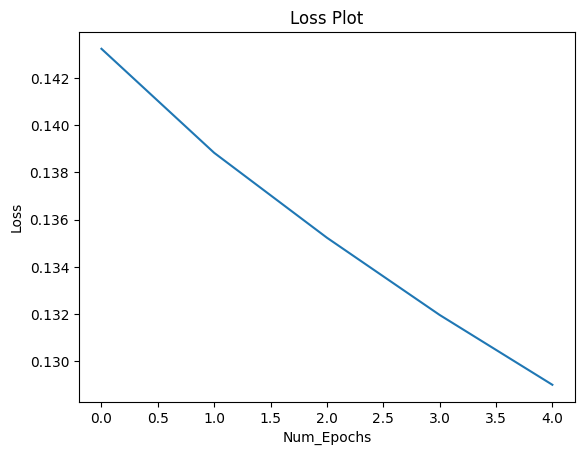

In [33]:
# Loss curve
plt.plot(loss_plot)
plt.xlabel('Num_Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# **Evaluation**

In [34]:
# This function generate captions on evaluation data
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(size_of_batch=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)

    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)


    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [35]:
# This function is used to plot attentions
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [36]:
print(img_name_train)
print(" *************\n")
print(img_name_val)

['/content/flickr30k_images/flickr30k_images/118939364.jpg', '/content/flickr30k_images/flickr30k_images/122156386.jpg', '/content/flickr30k_images/flickr30k_images/105223874.jpg', '/content/flickr30k_images/flickr30k_images/101093029.jpg', '/content/flickr30k_images/flickr30k_images/1088767354.jpg', '/content/flickr30k_images/flickr30k_images/128452798.jpg', '/content/flickr30k_images/flickr30k_images/1297871927.jpg', '/content/flickr30k_images/flickr30k_images/1094606832.jpg', '/content/flickr30k_images/flickr30k_images/1040426962.jpg', '/content/flickr30k_images/flickr30k_images/12393802.jpg', '/content/flickr30k_images/flickr30k_images/127450902.jpg', '/content/flickr30k_images/flickr30k_images/12736326.jpg', '/content/flickr30k_images/flickr30k_images/112178718.jpg', '/content/flickr30k_images/flickr30k_images/1097710887.jpg', '/content/flickr30k_images/flickr30k_images/10082348.jpg', '/content/flickr30k_images/flickr30k_images/1083240835.jpg', '/content/flickr30k_images/flickr30k

['<start>  دو ایشیائی یا ہسپانوی لوگ، ایک عورت اور ایک مرد، گاڑیوں کے گزرتے وقت شیشے کی کھڑکی کے سامنے اکٹھے بیٹھے ہیں۔ <end>', '<start>  دھوپ میں ایک آدمی سیاہ اور سفید بلاؤز میں ایک عورت کے گرد اپنا بازو رکھتا ہے۔ <end>', '<start>  دھوپ کے چشمے میں ایک آدمی عورت کے گرد اپنا بازو رکھتا ہے۔ <end>', '<start>  ایک مرد اور عورت کچھ ٹریفک کے سامنے پوز دے رہے ہیں۔ <end>', '<start>  بنچ پر بیٹھا ایک ایشیائی جوڑا۔ <end>']
101262930.jpg


<ipython-input-35-55c3ae4dac28>:15: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  plt.tight_layout()
<ipython-input-35-55c3ae4dac28>:15: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
<ipython-input-35-55c3ae4dac28>:15: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from current font.
  plt.tight_layout()
<ipython-input-35-55c3ae4dac28>:15: UserWarning: Glyph 1748 (\N{ARABIC FULL STOP}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph

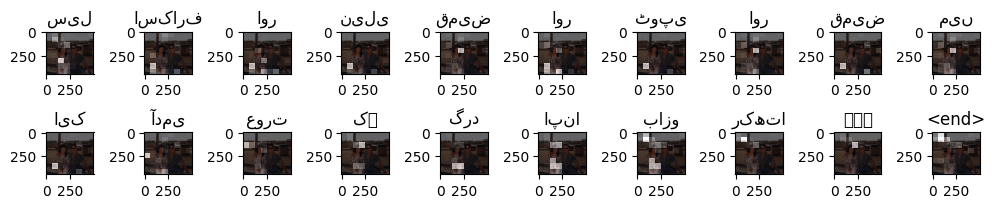

Prediction Caption: سیل اسکارف اور نیلی قمیض اور ٹوپی اور قمیض میں ایک آدمی عورت کے گرد اپنا بازو رکھتا ہے۔ <end>
Tokenized Prediction: ['سیل', 'اسکارف', 'اور', 'نیلی', 'قمیض', 'اور', 'ٹوپی', 'اور', 'قمیض', 'میں', 'ایک', 'آدمی', 'عورت', 'کے', 'گرد', 'اپنا', 'بازو', 'رکھتا', 'ہے۔', '<end>']
Tokenized Actual Captions: [['دو', 'ایشیائی', 'یا', 'ہسپانوی', 'لوگ،', 'ایک', 'عورت', 'اور', 'ایک', 'مرد،', 'گاڑیوں', 'کے', 'گزرتے', 'وقت', 'شیشے', 'کی', 'کھڑکی', 'کے', 'سامنے', 'اکٹھے', 'بیٹھے', 'ہیں۔'], ['دھوپ', 'میں', 'ایک', 'آدمی', 'سیاہ', 'اور', 'سفید', 'بلاؤز', 'میں', 'ایک', 'عورت', 'کے', 'گرد', 'اپنا', 'بازو', 'رکھتا', 'ہے۔'], ['دھوپ', 'کے', 'چشمے', 'میں', 'ایک', 'آدمی', 'عورت', 'کے', 'گرد', 'اپنا', 'بازو', 'رکھتا', 'ہے۔'], ['ایک', 'مرد', 'اور', 'عورت', 'کچھ', 'ٹریفک', 'کے', 'سامنے', 'پوز', 'دے', 'رہے', 'ہیں۔'], ['بنچ', 'پر', 'بیٹھا', 'ایک', 'ایشیائی', 'جوڑا۔']]
BLEU Score: 0.6109826701747818


In [49]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
img_name_val2 = ['/content/flickr30k_images/flickr30k_images/' + filename for filename in img_name_val]
image = img_name_val2[rid]
result, attention_plot = evaluate(image)
filename = os.path.basename(img_name_val2[rid])
real = list(df[df['Images']==filename]['Captions'])
print(real)
print(filename)

plot_attention(image, result, attention_plot)


cleaned = []
for i in range(len(real)):
    cleaned.append(real[i][7:-5])
predicted = ' '.join(result)

print ('Prediction Caption:', predicted)
#bs = sentence_bleu(cleaned, predicted)


"""
# predicted caption is tokenized
predicted_tokens = predicted.split()
print("Tokenized Prediction:", predicted_tokens)

# Actual caption is tokenized
cleaned_tokens = [ref.split() for ref in cleaned]
print("Tokenized Actual Captions:", cleaned_tokens)
"""

# BLEU score is calculated
bs =  sentence_bleu(cleaned, predicted)
print('BLEU Score:', bs)


In [51]:
#Testing images from the Validation

score = 0
for i in range (0,len(img_name_val),5):
    image = img_name_val2[i]
    result, attention_plot = evaluate(image)
    filename = os.path.basename(img_name_val2[i])
    real = list(df[df['Images']==filename]['Captions'])

    cleaned = []
    for i in range(len(real)):
        cleaned.append(real[i][7:-5])
    predicted = ' '.join(result)
    predicted_tokens = predicted.split()
    score += sentence_bleu(cleaned, predicted)

    bs = sentence_bleu(cleaned, predicted)
    print('BLEU Score:', bs)

val_bleu = score/len(img_name_val)*5
print("BLEU score on validation data: ",val_bleu)


BLEU Score: 0.9415101546914173
BLEU Score: 0.8285194103867187
BLEU Score: 0.6221625432804053
BLEU Score: 0.8350922473035578
BLEU Score: 0.7341691976523393
BLEU Score: 0.9337597913454168
BLEU Score: 0.9370940576526074
BLEU Score: 0.8981247548094166
BLEU Score: 0.8450099789576216
BLEU Score: 0.31831696262975007
BLEU Score: 0.841050496142499
BLEU Score: 0.8612003953267243
BLEU Score: 0.8178468362110027
BLEU Score: 0.8152179484456934
BLEU Score: 0.8465054698481382
BLEU Score: 0.7717345152941381
BLEU Score: 0.9212343761312088
BLEU Score: 0.8900393674323765
BLEU Score: 0.7273747133325258
BLEU Score: 0.7434303605795584
BLEU Score: 0.7032878231504399
BLEU Score: 0.6581666411492254
BLEU Score: 0.8042677376670065
BLEU Score: 0.923640950256368
BLEU Score: 0.8794245150375142
BLEU Score: 0.8394577145582771
BLEU Score: 0.7976181143393904
BLEU Score: 0.8733088023851866
BLEU Score: 0.7864558026440259
BLEU Score: 0.8482128670304425
BLEU Score: 0.670395074789709
BLEU Score: 0.9199732720441995
BLEU Score

# **Inference**

### **Image 01**

64400/64400 [==============================] - 0s 4us/step
Prediction Caption: دھاری دار کتا پانی میں ملا رہا ہے۔ <end>


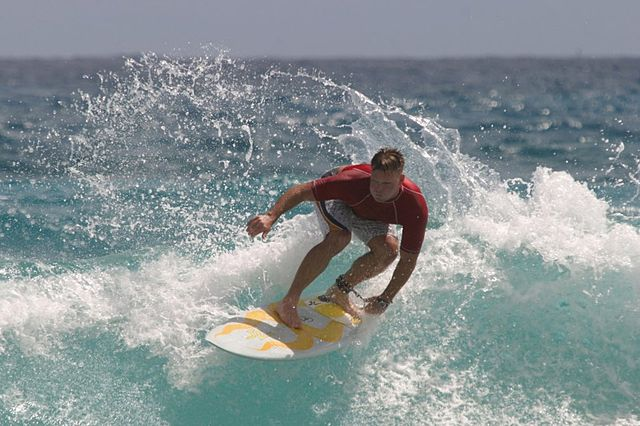

In [52]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-8:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

### **Image 02**

Prediction Caption: ٹوپی میں ملبوس ایک آدمی نارنجی رنگ کی قمیض میں عورت الیکٹرک مکسر پکڑے ہوئے ہے۔ <end>


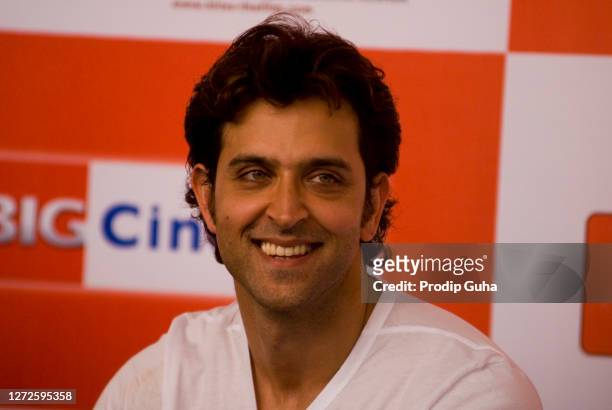

In [77]:
image_url = 'https://media.gettyimages.com/id/1272595358/photo/entertainment-india-2010.jpg?s=612x612&w=gi&k=20&c=KAXZCOk561VKp96nOGZDml05lCwigqYflOfXajv13XY='
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
#image_path = tf.keras.utils.get_file('image', origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

### **Image 03**

Prediction Caption: سنہرے بالوں والا نوجوان میں ایک کتاب کے ساتھ بستر پر بیٹھی ہے۔ <end>


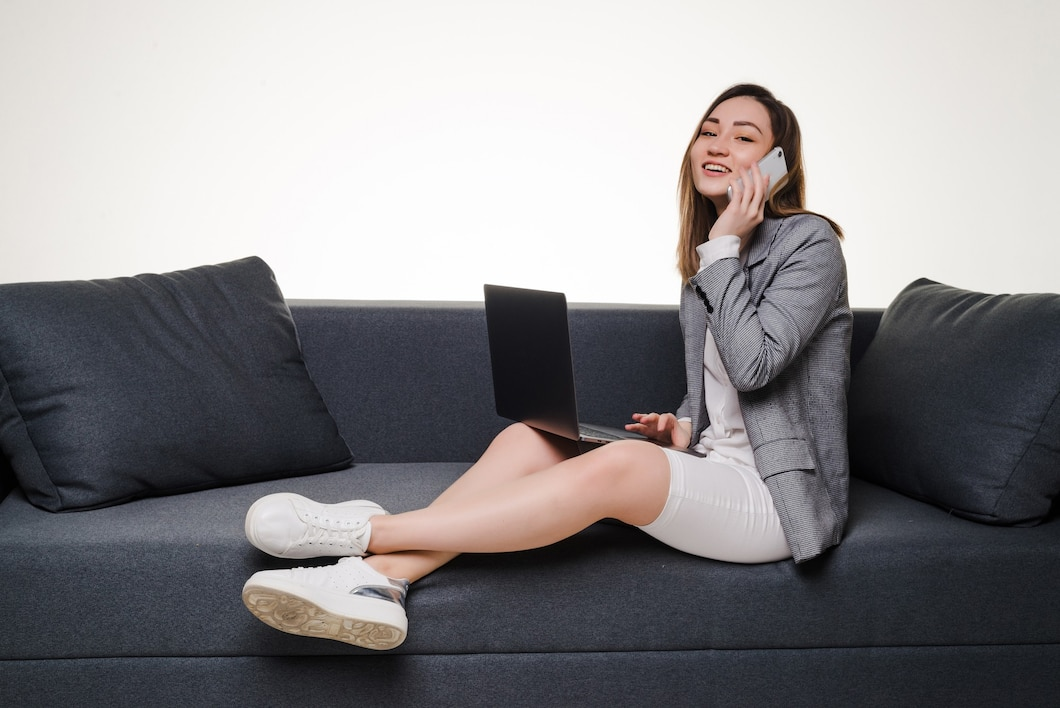

In [75]:
image_url = 'https://img.freepik.com/free-photo/asian-woman-phone-using-laptop-home-living-room-working-from-home-quarantine-lockdown_231208-10814.jpg?w=1060&t=st=1703419321~exp=1703419921~hmac=7c24b9bae4df101c24b438c37f38364949808d17c15ab4a8182b7b958c3787cc'
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
#image_path = tf.keras.utils.get_file('image', origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)

Prediction Caption: ایک پارک میں ایک بچے کو ایک دوسرے سے گھرے ہوئے ایک گروپ ایک موڑ کے گرد دھکیل رہے ہیں۔ <end>


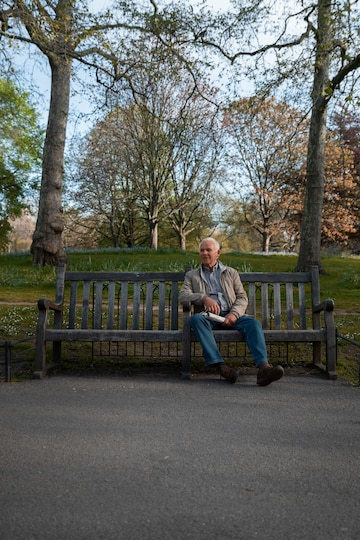

In [96]:
image_url = 'https://img.freepik.com/free-photo/full-shot-old-man-sitting-bench_23-2150493049.jpg?w=360&t=st=1703419636~exp=1703420236~hmac=5c24ab8492d89d65cd7c7c26cc3acb03d5fd3da25d084934f1ecd80222a3e4a4'
image_extension = image_url[-18:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
#image_path = tf.keras.utils.get_file('image', origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
Image.open(image_path)